## «Дополнительные главы теории случайных процессов»

### Экзаменационное задание

---

Кафедра МС ВМК МГУ, 4 курс

Фильтры: SR-UKF, PF(boot)

 -  Химическое приложение 1  – [1], стр. 13-20
 - [1] G.Yu. Kulikov, M.V. Kulikova, High-order accurate
continuous-discrete extended Kalman filter for chemical engineering, European Journal of Control, http://dx.doi.org/10.1016/j.ejcon.2014.11.003

Химическая реакция Van der Vusse, в   которой присутствуют случайные и/или заранее заданные возмущения, описывается 
непрерывно-дискретной стохастической динамической системой наблюдений: 

$$dX(t) = a(X(t))\,dt + G(t)\,dW(t), t> 0$$
$$Y_k = A(X(t_k)) + V_k, k \ge 1$$

Где $$X(t) = \left[c_A(t), c_B(t), T(t), T_J(t)\right]^T $$

- $c_A(t)$- молярная концентрация продукта A

- $c_B(t)$ -  молярная концентрация продукта B

- $T(t)$ - температура реактора

- $T_J(t)$ - температура охлаждающего кожуха

Желаемым продуктом реакции является B, тогда как C и D являются побочными  продуктами.

Реакция проводится в реакторе (CSTR) с охлаждающим кожухом.

![](https://cse.sc.edu/~gatzke/presentations/ifac99/img012.jpg)


Векторная функция cноса $a(X(t))$ имеет вид

$$ a(X(t)) = \begin{pmatrix}
 \frac{F}{V_R}[c_{A0}-c_A(t)]-k_{10}exp\left\{\frac{-E_1}{RT}\right\}c_A(t)-k_{30}exp\left\{\frac{-E_3}{RT}\right\}c_A^2(t)\\ 
 -\frac{F}{V_R}c_B(t)+k_{10}exp\left\{\frac{-E_1}{RT}\right\}c_A(t)-k_{20}exp\left\{\frac{-E_2}{RT}\right\}c_B(t)\\ 
 \frac{F}{V_R}[T_0-T(t)]+\frac{k_{\omega}A_R}{\rho C_pV_R}[T_J(t) -T(t)]-\left[k_{10}\Delta H_{r_1}exp\left\{\frac{-E_1}{RT}\right\}c_A(t)+k_{20}\Delta H_{r_2}exp\left\{\frac{-E_2}{RT}\right\}c_B(t)+k_{30}\Delta H_{r_3}exp\left\{\frac{-E_3}{RT}\right\}c_A^2(t) \right]/[\rho C_p]\\ 
 \frac{1}{m_J C_PJ}\left(\dot Q_J +k_{\omega}A_R[T(t)-T_J(t)] \right) \end{pmatrix}$$

Начальное состояние $X_0$ полагаем нормальным со средним $m = (c_A,c_B, T, T_J)$, где константы приведены в таблице ниже. Ковариационная матрица диагональна, с маленькими числами на главной диагонали(для стабильности). Т.е $X_0 \sim \mathcal{N}(m, 0.0001I)$

Возмущения в динамике задаются слагаемым $G(t)dW(t)$ где

- $G(t) = G = 0.03diag\{2.1404,1.0903,387.34,386.06\}$ - диффузионная матрица

- $W(t) \sim \mathcal{N}(0, I_4)$

 
 
В дискретные моменты времени поступают наблюдения, функция полезного сигнала имеет вид:

$$A(X(t_k)) = \begin{pmatrix} T(t_k)\\ T_J(t_k) \end{pmatrix}$$

То есть нам доступны в фиксированные моменты времени лишь температуры реактора и охлаждающего кожуха.

Шумы в наблюдениях имеют вид:

$$V_k \sim \mathcal{N}(0, R)$$

$$R = 0.003diag([387.34,386.06])$$

Для дискретизации уравнения динамики используется метод Эйлера-Маруямы

$$X_k = X_{k-1}+ a(X_{k-1})h +G\sqrt{h}W_{k-1}, \quad k = 1\dots N \quad W_{k} \sim \mathcal{N}(0,I)$$

$h = 0.0001$. Наблюдения поступают с шагом $0.01$

Остальные параметры уравнения динамики приведены в таблице:

![](table.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import e as e
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
%config InlineBackend.figure_formats = ['svg'] 
import scipy
from scipy.stats import multivariate_normal as normal
import warnings
import scipy.stats as sp
warnings.filterwarnings('ignore')
np.random.seed(52)

Запишем все нужные параметры для моделирования

In [2]:
h = 1e-4
delta = 0.01
t_end = 3 
n_states = 4
n_meas = 2
n_traj = 1000
N_grid = int(t_end/h)
K_grid = int(t_end/delta)
phi = 1.618


k10 = 1.287e12
k20 = 1.287e12
k30 = 9.043e9
E1R = 9758.3
E2R = 9758.3
E3R = 8560
Hr1 = 4.2
Hr2 = -11.0
Hr3 = -41.85
ro = 0.9342
C_p = 3.01
k_w = 4032
A_R = 0.215
V_R = 10
m_J = 5
C_PJ = 2.0
c_A = 2.1404
c_B = 1.0903
T = 387.34
T_J = 386.06
F = 141.9
Q_J = -1113.5
c_A0 = 5.1
T0 = 378.05
X0 = np.array([c_A, c_B, T, T_J]) # начальное состояние
G = 0.03*np.diag([2.1404,1.0903,387.34,386.06]) # диффузионная матрица
R = 0.003*np.diag([387.34,386.06]) # cov матрица шумов в наблюдениях
cov_0 = h*G@G.T
cov_uk0 = G@G.T
grid = np.linspace(0, t_end, int(t_end/h) + 1)

In [3]:
def a(X):
    return np.array([
        (F/V_R)*(c_A0 - X.T[0]) - X.T[0]*k10*e**(-E1R/T) - k30*(e**(-E3R/T))*(X.T[0]**2),
        (-F/V_R)*X.T[1] + X.T[0]*k10*e**(-E1R/T) - k20*X.T[1]*e**(-E2R/T),
        (F/V_R)*(T0-X.T[2])+((k_w*A_R)/(ro*C_p*V_R))*(X.T[3]-X.T[2]) - ( k10*Hr1*X.T[0]*e**(-E1R/T)+k20*Hr2*X.T[1]*e**(-E2R/T)+k30*Hr3*(X.T[0]**2)*e**(-E3R/T) )/(ro*C_p),
        (Q_J +k_w*A_R*(X.T[2]-X.T[3]))/(m_J*C_PJ)
    ]).T
def A(X):
    return np.array([X.T[2],X.T[3]]).T

Численно решаем уравнение динамики (СДУ), используя схему Эйлера-Маруямы. Получим траекторию состояния системы. И после этого определяем наблюдения

In [4]:
def data_simulation():
    X=[np.array([X0 for _ in range(n_traj)])]
    Y = []
    for i in range(1,N_grid+1):
        X.append(X[-1] + a(X[-1])*h + (np.sqrt(h) * G @ np.random.multivariate_normal(np.zeros(4), np.eye(4), size = n_traj).T).T)
    for i in range(1, N_grid+1, 100):
        Y.append(A(X[i]) + np.random.multivariate_normal(np.zeros(2), R, size = n_traj) )
    return np.array(X), np.array(Y)

In [5]:
X, Y = data_simulation() 

Вычисление тривиальной оценки

In [6]:
X_trivial = X.mean(axis = 1)

## Square Root Unscented Kalman Filter

Реализуем корневой вариант UKF, предложенный в cтатье [THE SQUARE-ROOT UNSCENTED KALMAN FILTER
FOR STATE AND PARAMETER-ESTIMATION](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.80.1421&rep=rep1&type=pdf)

$"$Одна из распространённых ошибок численной реализации фильтра
Калмана заключается в том, что из-за вычислительных ошибок матрица ковариации
ошибки оценки $k_t$ перестает быть неотрицательно определенной. Общая идея корневого
алгоритма заключается в том, чтобы описывать эволюцию во времени не $k_t$
, а ее «квадратного корня». $"$

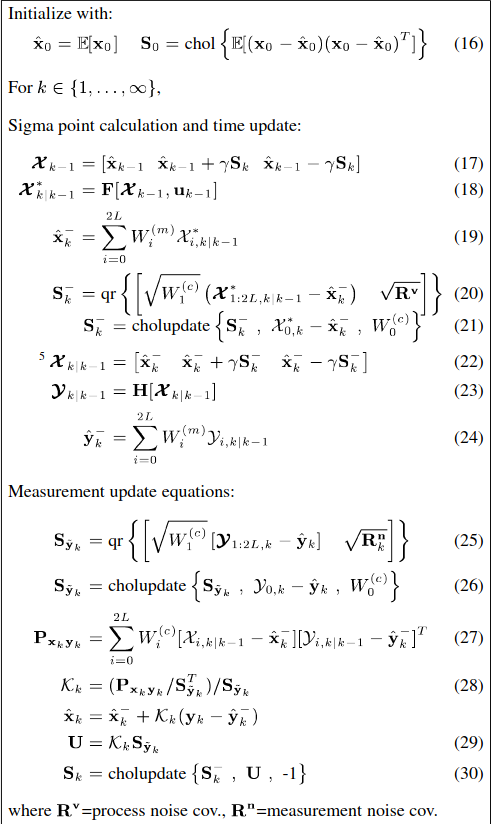

Поскольку в рамаках задачи предполагается, что наблюдения присутствуют в 100 раз реже, чем моделируется состояние, на шагах, когда наблюдение отсутствует будем полагать, что $S_k = S_k^{-}$ и $x_k = x_k^{-}$

Соответственно число сигма точек $2L+1$, $L$ - размерность состояния. Множество весов $\{W_i\}$ выбирается следующим образом:

$$W_0^{(m)} = \frac{\lambda}{L+\lambda} \quad W_0^{(c)} = \frac{\lambda}{L+\lambda} +(1-\alpha^2+\beta)$$

$$W_i^{(m)}= W_i^{(c)} = \frac{1}{2(L+\lambda)} \quad i = 1\dots 2L$$

Параметры $\alpha$, $\beta$, $\gamma$, $\lambda$:

$$\lambda = \alpha^2 L -L, \quad \gamma = \sqrt{L+\lambda}, \quad \beta = 2, \quad \alpha \in [10^{-4},1] $$

Положим $\alpha = 0.1$

In [7]:
np.random.seed(52)

In [8]:
def cholupdate2(A2, X, weight):
    '''Calculate chol(A + w x x')
        Code based on the following MATLAB snippet taken from Wikipedia
        function [L] = cholupdate(L,x)
            p = length(x);
            x = x';
            for k=1:p
                r = sqrt(L(k,k)^2 + x(k)^2);
                c = r / L(k, k);
                s = x(k) / L(k, k);
                L(k, k) = r;
                L(k,k+1:p) = (L(k,k+1:p) + s*x(k+1:p)) / c;
                x(k+1:p) = c*x(k+1:p) - s*L(k, k+1:p);
            end
        end
    '''
    if len(X.shape) == 1:
        X = X[np.newaxis, :]
    n_vec, n_dim = X.shape
    sign, weight = np.sign(weight), np.sqrt(np.abs(weight))
    X = weight * X
    for i in range(n_vec):
        x = X[i, :]
        for k in range(n_dim):
            r_squared = A2[k, k] ** 2 + sign * x[k] ** 2
            r = 0.0 if r_squared < 0 else np.sqrt(r_squared)
            c = r / A2[k, k]
            s = x[k] / A2[k, k]
            A2[k, k] = r
            A2[k, k + 1:] = (A2[k, k + 1:] + sign * s * x[k + 1:]) / c
            x[k + 1:] = c * x[k + 1:] - s * A2[k, k + 1:]
    return A2

def a_ukf(X):
    return np.array([
        (F/V_R)*(c_A0 - X[0])-X[0]*k10*e**(-E1R/T)-k30*(e**(-E3R/T))*(X[0]**2),
        (-F/V_R)*X[1]+X[0]*k10*e**(-E1R/T)-k20*X[1]*e**(-E2R/T),
        (F/V_R)*(T0-X[2])+((k_w*A_R)/(ro*C_p*V_R))*(X[3]-X[2]) - ( k10*Hr1*X[0]*e**(-E1R/T)+k20*Hr2*X[1]*e**(-E2R/T)+k30*Hr3*(X[0]**2)*e**(-E3R/T) )/(ro*C_p),
        (Q_J +k_w*A_R*(X[2]-X[3]))/(m_J*C_PJ)
    ])*h + X

def A_ukf(X):
    return np.array([X[2],X[3]])

def sigma_point_calculate(x,g,S):
    assert x.shape == (n_states,1)
    assert S.shape == (n_states,n_states)
    return np.hstack((x,x+g*S,x-g*S))

def cholupdate(S,x,sign):
    if sign == '+':
        return np.linalg.cholesky(S.T@S + x@x.T ).T
    elif sign == '-':
        return np.linalg.cholesky(S.T@S - x@x.T ).T
    else:
        raise NotImplemented

In [9]:
def srUKF(y, x0, f, h, Q, R,P0, alpha=0.1, beta=2):
    nx = x0.shape[0]
    ny = y.shape[0]  
    a = alpha
    b = beta 
    L = nx 
    l = (a**2)*L - L 
    g = np.sqrt(L + l) 
    Wm = np.hstack( ([[l/(L + l)]],  (1/(2*(L + l)))*np.ones([1, 2*L])) ) 
    Wc = np.hstack(([[(l/(L + l) + (1 - a**2 + b))]], (1/(2*(L + l)))*np.ones([1, 2*L]) )) 
    ix = np.arange(0, nx) 
    iy = np.arange(0, ny) 
    cholQ = np.linalg.cholesky(Q).T
    cholR = np.linalg.cholesky(R).T
    x = np.zeros([nx,N_grid+1])
    P = np.zeros([nx,nx,N_grid+1])
    x[:,0:1] = x0
    P[:,:,0] = np.linalg.cholesky(P0).T
    for i in range(1,N_grid+1):
        Xi = sigma_point_calculate(x = x[:,i-1:i], g = g, S = P[:,:,i]) 
        for j in range(0,2*L+1):
            Xi[:,j] = f(Xi[:,j]) 
        x[:,i:i+1] = Xi@Wm.T # прогноз
        qr_Q,qr_R = scipy.linalg.qr( np.hstack([np.sqrt(Wc[0,1]) * (Xi[:,1:] - x[:,i:i+1] ), cholQ.T]).T  )
        S = cholupdate(qr_R[np.ix_(ix,ix)],np.sqrt(np.abs(Wc[0,0]))*(Xi[:,0:1] - x[:,i:i+1]), '+')
        P[:,:,i] = S # прогноз
        if i % 100 == 1: #  Коррекция - в момент поступления очередного наблюдения
            Yi = np.zeros([ny, 2*L+1])
            Xi = sigma_point_calculate(x = x[:,i:i+1], g = g, S = P[:,:,i])
            for j in range(0,2*L+1):
                Yi[:,j] = h(Xi[:,j])
            y_hat = (Yi@Wm.T).reshape(ny,1) 
            qr_Q,qr_R = scipy.linalg.qr( np.hstack([np.sqrt(np.abs(Wc[0,1])) * (Yi[:,1:] - y_hat), cholR.T]).T  )
            S_y = cholupdate(qr_R[np.ix_(iy,iy)],np.sqrt(np.abs(Wc[0,0]))*(Yi[:,0:1] - y_hat), '+')
            P_xy = 0
            for j in range(0,2*L+1):
                P_xy = P_xy +Wc[0,j]*((Xi - x[:,i:i+1]))[:,j:j+1]@((Yi-y_hat)[:,j:j+1]).T
            Kb = P_xy@np.linalg.pinv(S_y.T @ S_y)
            x[:,i:i+1] = x[:,i:i+1] + Kb@(y[:,i//100].reshape(ny,1) - y_hat) # коррекция
            U = Kb@S_y
            S = P[:,:,i].copy()
            for j in range(U.shape[1]):
                S = cholupdate(S ,U[:,j][:,np.newaxis],'-')
            P[:,:,i] = S # коррекция
    return x


In [10]:
X_estimate_srUKF = np.zeros((N_grid+1,n_traj,n_states))
for j in range(n_traj):
    X_estimate_srUKF[:,j,:] = srUKF(Y[:,j,:].T, X0[:,np.newaxis],a_ukf, A_ukf,cov_uk0, R, cov_uk0).T

## Particle Filter(boot)

**Бутстреп фильтр.**
1. **Начальное условие**
  - Моделирование выборки частиц:
$$
\{X_0^{(i)} \}_{i=\overline{1,N}}: \quad X_0^{(i)} \sim \pi_0(x)
$$
 - Вычисление весов:
 $$
 w_0^{(i)} \equiv \frac{1}{N},\quad i=\overline{1,N}
$$
 - Вычисление оценки фильтрации:
$$
\hat{X}_0 = \sum\limits_{i=1}^N w_0^{(i)}X_0^{(i)}
$$
2. **Рекурсия**
 - Моделирование распространения частиц: на предыдущем шаге $t-1$ известен набор частиц и весов $\left\{(X_{t-1}^{(i)},w_{t-1}^{(i)})\right\}_{i=\overline{1,N}}$ . Моделируются случайные значения (частицы)
$$
X_t^{(i)} \sim \pi(x|X_{t-1}^{(i)})
$$
 - Вычисление весов:
$$
   \tilde{w}_t^{(i)} = w_{t-1}^{(i)}\pi(Y_t|X_t^{(i)})
$$
 - Нормировка:
$$
w_t^{(i)} = \frac{\tilde{w}_t^{(i)}}{\sum_{j=1}^N \tilde{w}_t^{(j)}}
$$
 - Вычисление оценки фильтрации:
$$
\hat{X}_t = \sum\limits_{i=1}^N w_t^{(i)}X_t^{(i)}
$$
3. **Перестроение выборки по значимости**
 - Вычиcлить
$$
n_{eff} = \frac{1}{\sum_{i=1}^N (w_t^{(i)})^2}
$$
  - Если
$$
n_{eff} < \frac{N}{10}
$$
  - То смоделировать новую выборку $\{\mathcal{X}_t^{(i)}\}_{i = \overline {1,N}} $ из распределения  $\left\{(X_{t}^{(i)},w_{t}^{(i)})\right\}_{i = \overline {1,N}} $  . Перед следующим шагом 2 положить
 $$
   X_t^{(i)} \equiv  \mathcal{X}_t^{(i)},\quad w_t^{(i)} \equiv \frac{1}{N},\quad i = \overline{1,N}
 $$

In [11]:
def new_particles_and_weights(N_particles, X_previous, w_previous, Y, flag):
    X = np.array([[np.random.multivariate_normal(vec, h*G@G.T) 
                   for vec in (a(pcs)*h + pcs)] for pcs in X_previous])
    if flag:
        w = np.array([[sp.multivariate_normal(x, R).pdf(y) for x,y in zip (A(pcs), Y)] * weight
                      for pcs, weight in zip(X_previous, w_previous)])
        if np.any(np.all(w == 0, axis = 0)):
            w = w_previous
        else:
            w /= np.sum(w, axis = 0)
    else:
        w = w_previous
    return X, w

In [12]:
def PF(Y, N_particles):
    pcs = np.random.multivariate_normal(X0, cov_0, size=(N_particles, n_traj))
    w = np.array([np.repeat([1/N_particles], N_particles) for i in range(n_traj)]).T
    X_estimate_PF = [np.einsum('ab,abc -> bc', w, pcs)]
    for k in range(1, N_grid+1):
        if k % 100 == 1:
            pcs, w = new_particles_and_weights(N_particles, pcs, w, Y[k//100], True)
        else:
            pcs,w  = new_particles_and_weights(N_particles, pcs, w, Y[0], False)
        X_estimate_PF.append(np.einsum('ab,abc -> bc', w, pcs))
        n_eff = 1/np.sum(w ** 2, axis = 0)
        check = np.repeat([False], n_traj) if np.any(np.isnan(n_eff)) else n_eff < N_particles/10
        if np.any(check):
            X, w = zip(*[ (pcs[:, j, :][np.random.choice(range(N_particles), N_particles, p=weights)],
            np.ones(N_particles)/N_particles) if flag else (pcs[:, j, :], weights)
                for weights, (j, flag) in zip(w.T, enumerate(check))])
            pcs, w = np.array([np.array(X)[:,j,:] for j in range(X[0].shape[0])]), np.array(w).T            
    return np.array(X_estimate_PF)

In [13]:
X_estimate_PF = PF(Y, 50) 

In [46]:
i = 0

In [15]:
sigma3_UKF = 3*X_estimate_srUKF.std(axis = 1)

### Результаты оценивания координаты состояния $c_A$ 

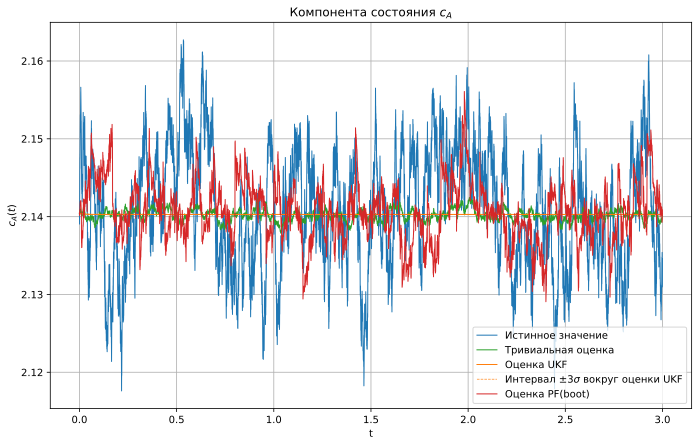

In [16]:
plt.figure(figsize = (11.5,11.5/phi))
plt.plot(grid,X[:,i,0], linewidth = 1 ,color = 'tab:blue', label = 'Истинное значение')
plt.plot(grid,X_trivial[:,0], linewidth = 1 ,color = 'tab:green', label = 'Тривиальная оценка')
plt.plot(grid,X_estimate_srUKF[:,i,0], linewidth = 1,color = 'tab:orange', label = 'Оценка UKF')
plt.plot(grid,sigma3_UKF[:,0]  + X_estimate_srUKF[:,i,0], linewidth = 0.7, 
         linestyle = '--', label = 'Интервал $\pm 3\sigma$ вокруг оценки UKF', color = 'tab:orange')
plt.plot(grid,-sigma3_UKF[:,0]  + X_estimate_srUKF[:,i,0], linewidth = 0.7, 
         linestyle = '--', color = 'tab:orange')
plt.plot(grid,X_estimate_PF[:,i,0], linewidth = 1, color = 'tab:red', label = 'Оценка PF(boot)')
plt.xlabel('t')
plt.ylabel('$c_A(t)$')
plt.title('Компонента состояния $с_A$')
plt.grid()
plt.legend();
plt.show();

### Результаты оценивания координаты состояния $c_B$ 

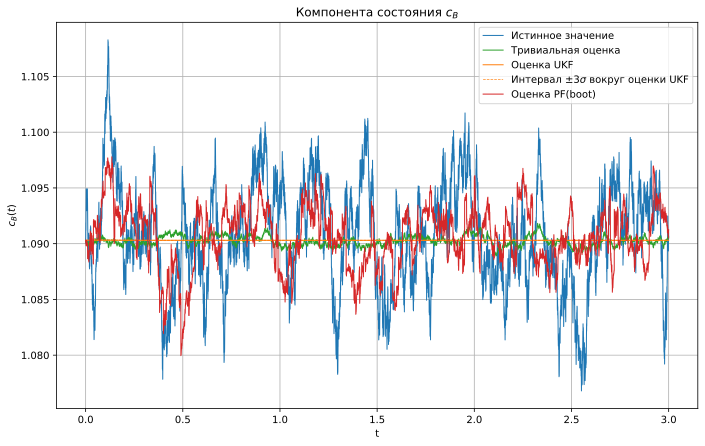

In [47]:
plt.figure(figsize = (11.5,11.5/phi))
plt.plot(grid,X[:,i,1], linewidth = 1 ,color = 'tab:blue', label = 'Истинное значение')
plt.plot(grid,X_trivial[:,1], linewidth = 1 ,color = 'tab:green', label = 'Тривиальная оценка')
plt.plot(grid,X_estimate_srUKF[:,i,1], linewidth = 1, color = 'tab:orange', label = 'Оценка UKF')
plt.plot(grid,sigma3_UKF[:,1]  + X_estimate_srUKF[:,i,1], linewidth = 0.7, 
         linestyle = '--', label = 'Интервал $\pm 3\sigma$ вокруг оценки UKF', color = 'tab:orange')
plt.plot(grid,-sigma3_UKF[:,1]  + X_estimate_srUKF[:,i,1], linewidth = 0.7, 
         linestyle = '--', color = 'tab:orange')
plt.plot(grid,X_estimate_PF[:,i,1], linewidth = 1, color = 'tab:red', label = 'Оценка PF(boot)')
plt.xlabel('t')
plt.ylabel('$c_B(t)$')
plt.title('Компонента состояния $c_B$')
plt.grid()
plt.legend();
plt.show();

### Результаты оценивания координаты состояния $T$ 

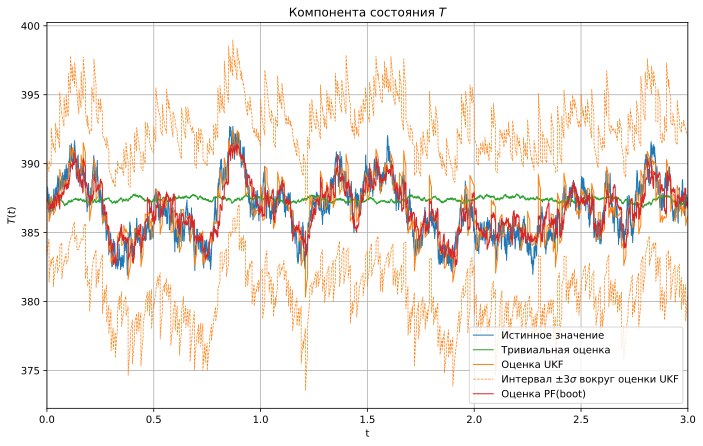

In [18]:
plt.figure(figsize = (11.5,11.5/phi))
plt.plot(grid,X[:,i,2], linewidth = 1 , color = 'tab:blue', label = 'Истинное значение')
plt.plot(grid,X_trivial[:,2], linewidth = 1 ,color = 'tab:green', label = 'Тривиальная оценка')
plt.plot(grid,X_estimate_srUKF[:,i,2], linewidth = 1,color = 'tab:orange', label = 'Оценка UKF')
plt.plot(grid,sigma3_UKF[:,2]  + X_estimate_srUKF[:,i,2], linewidth = 0.7, 
         linestyle = '--', label = 'Интервал $\pm 3\sigma$ вокруг оценки UKF', color = 'tab:orange')
plt.plot(grid,-sigma3_UKF[:,2]  + X_estimate_srUKF[:,i,2], linewidth = 0.7, 
         linestyle = '--', color = 'tab:orange')
plt.plot(grid,X_estimate_PF[:,i,2], linewidth = 1, color = 'tab:red', label = 'Оценка PF(boot)')
plt.xlabel('t')
plt.ylabel('$T(t)$')
plt.title('Компонента состояния $T$')
plt.grid()
plt.legend();
plt.show();

### Результаты оценивания координаты состояния $T_J$ 

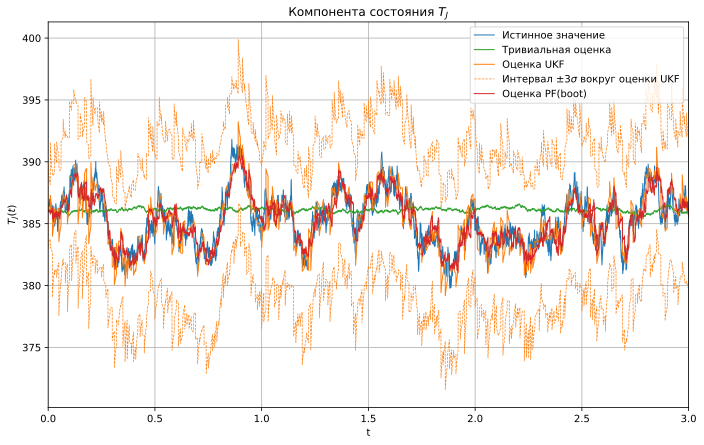

In [19]:
plt.figure(figsize = (11.5,11.5/phi))
plt.plot(grid,X[:,i,3], linewidth = 1 , color = 'tab:blue', label = 'Истинное значение')
plt.plot(grid,X_trivial[:,3], linewidth = 1 ,color = 'tab:green', label = 'Тривиальная оценка')
plt.plot(grid,X_estimate_srUKF[:,i,3], linewidth = 1, color = 'tab:orange', label = 'Оценка UKF')
plt.plot(grid,sigma3_UKF[:,3]  + X_estimate_srUKF[:,i,3], linewidth = 0.7, 
         linestyle = '--', label = 'Интервал $\pm 3\sigma$ вокруг оценки UKF', color = 'tab:orange')
plt.plot(grid,-sigma3_UKF[:,3]  + X_estimate_srUKF[:,i,3], linewidth = 0.7, 
         linestyle = '--', color = 'tab:orange')
plt.plot(grid,X_estimate_PF[:,i,3], linewidth = 1, color = 'tab:red', label = 'Оценка PF(boot)')
plt.xlabel('t')
plt.ylabel('$T_J(t)$')
plt.title('Компонента состояния $T_J$')
plt.grid()
plt.legend();
plt.show();

## Характеристики точности оценивания координат

In [20]:
sigma = X.std(axis = 1)
sigma_UKF = (X-X_estimate_srUKF).std(axis = 1)
sigma_PF = (X-X_estimate_PF).std(axis = 1)

### Xарактеристики точности оценивания координаты $c_A$

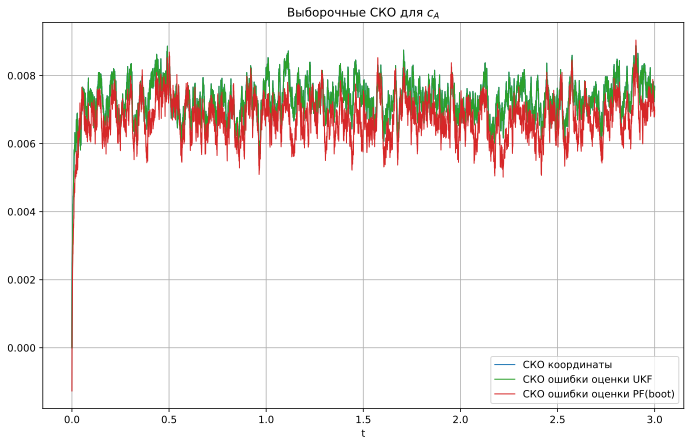

In [65]:
plt.figure(figsize = (11.5,11.5/phi))
plt.plot(grid,sigma[:,0], linewidth = 1 , color = 'tab:blue', label = 'СКО координаты')
plt.plot(grid,sigma_UKF[:,0], linewidth = 1, color = 'tab:green', label = 'СКО ошибки оценки UKF')
plt.plot(grid,sigma_PF[:,0], linewidth = 1, color = 'tab:red', label = 'СКО ошибки оценки PF(boot)')
plt.xlabel('t')
plt.title('Выборочные СКО для $c_A$')
plt.grid()
plt.legend();
plt.show();

###  Xарактеристики точности оценивания координаты $c_B$

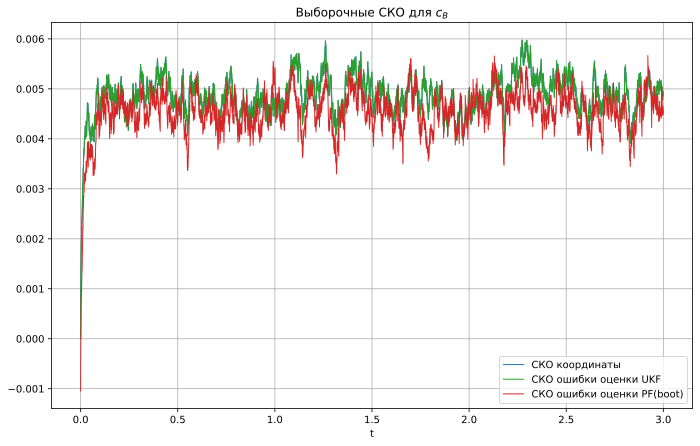

In [62]:
plt.figure(figsize = (11.5,11.5/phi))
plt.plot(grid,sigma[:,1], linewidth = 1 , color = 'tab:blue', label = 'СКО координаты')
plt.plot(grid,sigma_UKF[:,1], linewidth = 1, color = 'tab:green', label = 'СКО ошибки оценки UKF')
plt.plot(grid,sigma_PF[:,1], linewidth = 1, color = 'tab:red', label = 'СКО ошибки оценки PF(boot)')
plt.xlabel('t')
plt.title('Выборочные СКО для $c_B$')
plt.grid()
plt.legend();
plt.show();

### Xарактеристики точности оценивания координаты $T$

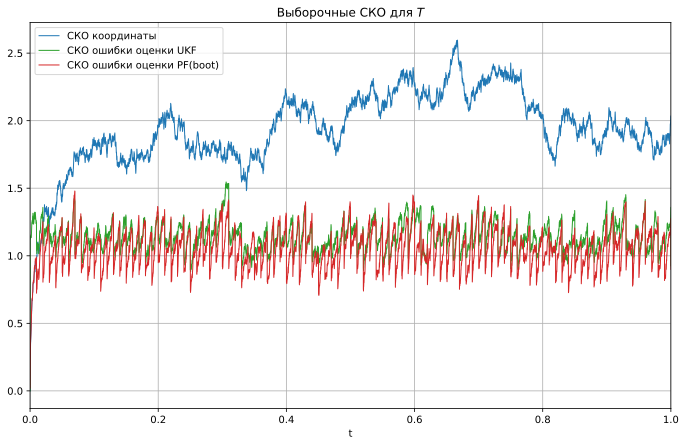

In [23]:
plt.figure(figsize = (11.5,11.5/phi))
plt.plot(grid,sigma[:,2], linewidth = 1 , color = 'tab:blue', label = 'СКО координаты')
plt.plot(grid,sigma_UKF[:,2], linewidth = 1, color = 'tab:green', label = 'СКО ошибки оценки UKF')
plt.plot(grid,sigma_PF[:,2], linewidth = 1, color = 'tab:red', label = 'СКО ошибки оценки PF(boot)')
plt.xlabel('t')
plt.title('Выборочные СКО для $T$')
plt.grid()
plt.legend()
plt.show();

### Xарактеристики точности оценивания координаты $T_J$

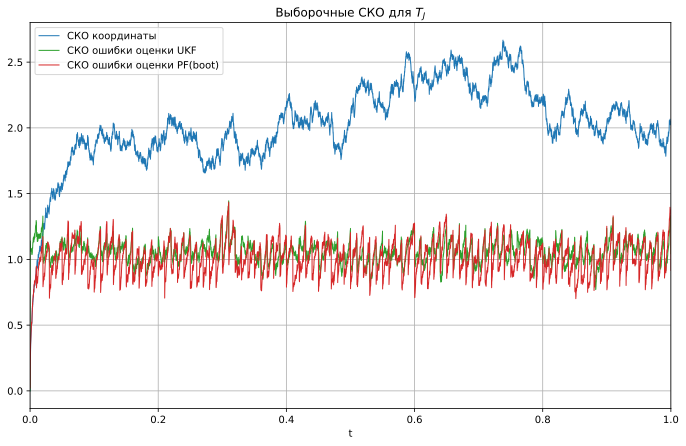

In [24]:
plt.figure(figsize = (11.5,11.5/phi))
plt.plot(grid,sigma[:,3], linewidth = 1 , color = 'tab:blue', label = 'СКО координаты')
plt.plot(grid,sigma_UKF[:,3], linewidth = 1, color = 'tab:green', label = 'СКО ошибки оценки UKF')
plt.plot(grid,sigma_PF[:,3], linewidth = 1, color = 'tab:red', label = 'СКО ошибки оценки PF(boot)')
plt.xlabel('t')
plt.title('Выборочные СКО для $T_J$')
plt.grid()
plt.legend()
plt.show();

Метрики для $T$ и  $T_J$- берем мат ожидание квадратов отклонений оценок от точного значения координат для каждого момента времени и после усредняем по времени.

In [33]:
M_UKF = ((X-X_estimate_srUKF)**2).mean(axis = 1)
M_PF = ((X-X_estimate_PF)**2).mean(axis = 1)
M_UKF[:,2].mean(),M_PF[:,2].mean(), M_UKF[:,3].mean(), M_PF[:,3].mean()

(1.3436778185575775,
 1.1561166477539835,
 1.1499991394368339,
 1.0209430677230067)

## Выводы

В данной работе я реализовал square-root unscented Kalman filter (SR-UKF) и Bootstrap Particle Filter(PF(boot)). SR-UKF обеспечивает
неотрицательную определенность ковариации состояния, также
обусловленность квадратного корня $s$ лучше, чем $k=ss^T$ 

PF имеет некоторое сходство с UKF в том, что он преобразует набор точек с помощью известных нелинейных уравнений и объединяет результаты для оценки среднего значения и ковариации состояния. Однако в фильтре частиц точки выбираются случайным образом(генерируются), тогда как в UKF точки выбираются на основе алгоритма. Из-за этого количество частиц, используемых в PF, обычно должно быть намного больше, чем количество сигма точек в UKF. Также при увеличении числа частиц в PF качество фильтра увеличивается

Согласно характеристикам точности оценивания координат  состояния $X(t) = \left[c_A(t), c_B(t), T(t), T_J(t)\right]^T$ химической реакции Van der Vusse мы имеем сравнительный результат:

- кооридината $T$ - Фильтры PF(boot) и SR-UKF имеют сравнимое СКО, в разы меньшее СКО ошибки тривиальной оценки. Оба фильтра значительно лучше чем тривиальная оценка - это видно и по отдельным графикам. Причем PF(boot) оказался в этом случае чуть лучше - график СКО его ошибки оценки слегка ниже, метрика меньше.Таким образом, по координате $T$ фильтр PF(boot) оказался лучше чем  SR-UKF. Оба фильтра лучше чем тривиальная оценка
- координата $T_J$ - Фильтры PF(boot) и SR-UKF имеют сравнимое СКО, в разы меньшее СКО ошибки тривиальной оценки. Оба фильтра значительно лучше чем тривиальная оценка - это видно и по отдельным графикам. Причем PF(boot) оказался в этом случае чуть лучше - метрика меньше.Таким образом, по координате $T_J$ фильтр PF(boot) оказался лучше чем  SR-UKF. Оба фильтра лучше чем тривиальная оценка
- координата $c_A$ - СКО координаты практически полностью совпадает с СКО ошибки SR-UKF (Зеленый и синий графики наложились). PF(boot) имеет сравнимое качество, но чуть лучше. В целом СКО ошибок оценок довольно мало.Таким образом, по координате $c_A$ фильтр PF(boot) оказался лучше чем SR-UKF.
- координата $c_B$ - СКО координаты практически полностью соовпадает с СКО ошибки SR-UKF (Зеленый и синий графики наложились). PF(boot) имеет сравнимое качество, но чуть лучше. В целом СКО ошибок оценок довольно мало.Таким образом, по координате $c_B$ фильтр PF(boot) оказался лучше чем SR-UKF

Таким образом, фильтр PF(boot) дал лучший результат c точки зрения  точности оценивания, однако он требует больше вычислительных ресурсов и времени работы алгоритма.